# <u>**Classification for the sales dataset**</u>

In [1]:
! pip install pyspark seaborn

In [2]:
# libraries

import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

import seaborn as sns
from pyspark.sql.window import Window
from pyspark.ml.feature import Bucketizer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import broadcast
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import OneVsRest

from pyspark.sql.functions import col, when, log
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import year, month, dayofweek, when, current_date, datediff

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/Colab Notebooks/Project/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
spark = SparkSession.builder.appName("Project511_ML_SALE").master("local[*]").config("spark.driver.maxResultSize", "2g").getOrCreate()

## Importing the dataset

In [5]:
sale_df = spark.read.format("parquet").load(google_drive_path + "sale_tfidf.parquet")

In [6]:
sale_df.show()

+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|start_date|  end_date|                  l2|                l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|operation_type|         coordinates|amount_in_euro|    full_description|      processed_text|             bigrams|            trigrams|   features_unigrams|    features_bigrams|   features_trigrams|            features|      final_features|
+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+--------------+--------------------+--------------------+--------------------+--------

In [7]:
sale_df.count()

210341

In [8]:
sale_df.dtypes

[('start_date', 'date'),
 ('end_date', 'string'),
 ('l2', 'string'),
 ('l3', 'string'),
 ('rooms', 'int'),
 ('bedrooms', 'int'),
 ('bathrooms', 'int'),
 ('surface_total', 'double'),
 ('surface_covered', 'double'),
 ('property_type', 'string'),
 ('operation_type', 'string'),
 ('coordinates', 'array<double>'),
 ('amount_in_euro', 'double'),
 ('full_description', 'string'),
 ('processed_text', 'array<string>'),
 ('bigrams', 'array<string>'),
 ('trigrams', 'array<string>'),
 ('features_unigrams', 'vector'),
 ('features_bigrams', 'vector'),
 ('features_trigrams', 'vector'),
 ('features', 'vector'),
 ('final_features', 'vector')]

In [9]:
# dropping some useless columns from text analytics
sale_df = sale_df.drop("full_description", "processed_text", "bigrams", "trigrams",
                       "features_unigrams", "features_bigrams", "features_trigrams", "features")

## Classes Creation

**Fixing some incorrect values**



In [10]:
# casting amount to euro to integer (round to the nearest integer)
sale_df = sale_df.withColumn("amount_in_euro", round("amount_in_euro", 2))

In [11]:
sale_df.select("amount_in_euro").agg(min("amount_in_euro"), max("amount_in_euro"), avg("amount_in_euro")).show()

+-------------------+-------------------+-------------------+
|min(amount_in_euro)|max(amount_in_euro)|avg(amount_in_euro)|
+-------------------+-------------------+-------------------+
|              10.01|    9.19999999908E9|  233904.8059317496|
+-------------------+-------------------+-------------------+



We found some extreme values and we will discard them because there is no logic in buying a house that is 10€ or 9.2x10^9€.

In [12]:
sale_df = sale_df.filter(col("amount_in_euro") != 9199999999.08)

In [13]:
sale_df = sale_df.filter(col("amount_in_euro") != 10.01)

In [14]:
sale_df.select("amount_in_euro").agg(min("amount_in_euro"), max("amount_in_euro"), avg("amount_in_euro")).show()

+-------------------+-------------------+-------------------+
|min(amount_in_euro)|max(amount_in_euro)|avg(amount_in_euro)|
+-------------------+-------------------+-------------------+
|              373.1|     1.0111111101E8|  190168.1132619249|
+-------------------+-------------------+-------------------+



**Log-transformation of the target variable to reduce its skewness**

In [15]:
# Log-transform the price to reduce skewness
sale_df = sale_df.withColumn("log_price", log(col("amount_in_euro")))

# min and max for the log price
log_price_stats = sale_df.agg(F.min(col("log_price")).alias("min_log_price"),
                          F.max(col("log_price")).alias("max_log_price")).collect()

min_log_price = log_price_stats[0]["min_log_price"]
max_log_price = log_price_stats[0]["max_log_price"]

# bins for the log-transformed prices
bin_edges = list(np.linspace(min_log_price, max_log_price, num=5))
bucketizer = Bucketizer(splits=bin_edges, inputCol="log_price", outputCol="price_bucket")


quantiles = sale_df.approxQuantile("log_price", [0.2, 0.4, 0.6, 0.8], 0.05)
# Include the minimum and maximum values to cover all possible values
min_price = sale_df.agg(F.min("log_price")).collect()[0][0]
max_price = sale_df.agg(F.max("log_price")).collect()[0][0]
quantiles = [min_price] + quantiles + [max_price]

bucketizer = Bucketizer(splits=quantiles, inputCol="log_price", outputCol="price_bucket")
sale_df = bucketizer.transform(sale_df)

In [16]:
sale_df.groupBy("price_bucket").count().show() # displaying the buckets

+------------+-----+
|price_bucket|count|
+------------+-----+
|         0.0|41710|
|         1.0|40238|
|         4.0|50673|
|         3.0|38267|
|         2.0|39451|
+------------+-----+



In [17]:
splits = bucketizer.getSplits()
# Display the range of each bin
print("Bin ranges (original scale):")
for i in range(1, len(splits)):
    print(f"Bin {i-1}: [{np.exp(splits[i-1])}, {np.exp(splits[i])})")

Bin ranges (original scale):
Bin 0: [373.09999999999985, 53360.00000000001)
Bin 1: [53360.00000000001, 84639.99999999997)
Bin 2: [84639.99999999997, 128800.0000000001)
Bin 3: [128800.0000000001, 210680.00000000015)
Bin 4: [210680.00000000015, 101111111.00999996)


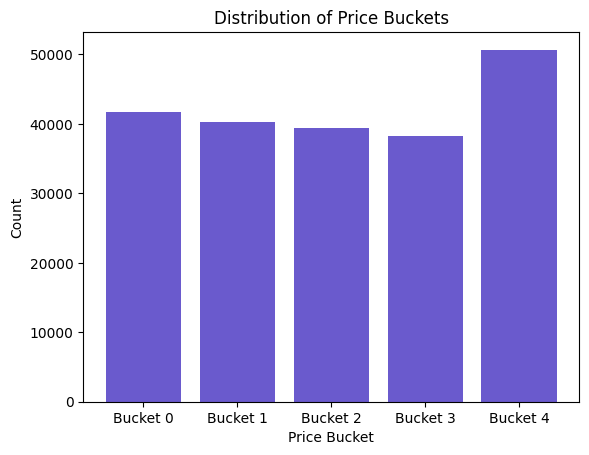

In [18]:
# Barplot of each bucket
bucket_counts = sale_df.groupBy("price_bucket").count().orderBy("price_bucket").toPandas()

plt.bar(bucket_counts["price_bucket"], bucket_counts["count"], color='slateblue')
plt.xlabel('Price Bucket')
plt.ylabel('Count')
plt.title('Distribution of Price Buckets')
plt.xticks(bucket_counts["price_bucket"], [f"Bucket {int(b)}" for b in bucket_counts["price_bucket"]])
plt.show()

In [19]:
# Step 1: Count each property_type within each price_bucket
property_count = sale_df.groupBy("price_bucket", "property_type").count()

# Step 2: Calculate total counts for each property_type across all buckets
total_property_count = property_count.groupBy("property_type").agg(F.sum("count").alias("total_count"))

# Step 3: Join the counts with the totals and calculate the percentage
percentage_df = property_count.join(total_property_count, "property_type") \
    .withColumn("percentage", round(F.col("count") / F.col("total_count") * 100, 2))

# Step 4: Select the relevant columns and order for readability
result_df = percentage_df.select(
    "price_bucket", "property_type", "count", "total_count", "percentage"
).orderBy("price_bucket", "property_type")

# Step 5: Results
result_df.orderBy("price_bucket", "count", ascending=False).show(50)

+------------+----------------+-----+-----------+----------+
|price_bucket|   property_type|count|total_count|percentage|
+------------+----------------+-----+-----------+----------+
|         4.0|           House|18078|      40822|     44.28|
|         4.0|       Apartment|12533|      72048|      17.4|
|         4.0|           Other|11362|      58134|     19.54|
|         4.0|             Lot| 4450|      21807|     20.41|
|         4.0|Commercial Space| 1590|       3787|     41.99|
|         4.0|          Duplex| 1274|       7706|     16.53|
|         4.0|          Office|  758|       2743|     27.63|
|         4.0|       Warehouse|  495|        804|     61.57|
|         4.0|   Country House|   98|        309|     31.72|
|         4.0|          Garage|   35|       2179|      1.61|
|         3.0|       Apartment|14361|      72048|     19.93|
|         3.0|           House| 9696|      40822|     23.75|
|         3.0|           Other| 8821|      58134|     15.17|
|         3.0|          

In [20]:
sale_df.show()

+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+--------------+--------------------+------------------+------------+
|start_date|  end_date|                  l2|                l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|operation_type|         coordinates|amount_in_euro|      final_features|         log_price|price_bucket|
+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+--------------+--------------------+------------------+------------+
|2020-09-14|9999-12-31|Bs.As. G.B.A. Zon...|             Morón|    3|       2|        1|       438.17|         347.07|       Duplex|          Sale|[-34.656478881835...|       74620.0|(17000,[0,1,2,3,4...|11.220163846775149|         1.0|
|2020-10-13|9999-12-31|     Capital Federal|        

In [21]:
sale_df = sale_df.drop("amount_in_euro", "log_price") # dropping the price columns

## Encoding

### 'Operation Type'

There is no need for encoding because we have one unique value in the specific column => drop

In [22]:
sale_df = sale_df.drop("operation_type")

### 'Start Date' and 'End Date'

In [23]:
# extracting the year, month and day of the week of each date of the start date of the advertisment
sale_df = sale_df.withColumn("start_year", year("start_date")) \
                 .withColumn("start_month", month("start_date")) \
                 .withColumn("start_day_of_week", dayofweek("start_date"))

In [24]:
# extracting the year, month and day of the week of each date of the end date of the advertisment
sale_df = sale_df.withColumn("end_year", year("end_date")) \
                 .withColumn("end_month", month("end_date")) \
                 .withColumn("end_day_of_week", dayofweek("end_date"))

In [25]:
sale_df = sale_df.withColumn("is_active", F.when(col("end_year") == 9999, 1).otherwise(0))
                      # creating an extra column when there is no end date
                      # '9999-MM-DD' to represent active advertisments (till the day the dataset has been published on Kaggle)

In [26]:
sale_df = sale_df.withColumn("end_year", F.when(col("end_year") == 9999, 2021).otherwise(col("end_year")))
                      # transforming the end_year where there is 9999 to 2021 because this is the date when the dataset was published in Kaggle

In [27]:
sale_df.show()

+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+
|start_date|  end_date|                  l2|                l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|         coordinates|      final_features|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|
+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+
|2020-09-14|9999-12-31|Bs.As. G.B.A. Zon...|             Morón|    3|       2|        1|       438.17|         347.07|       Duplex|[-34.656478881835...|(17000,[0,1,2,3,4...|    

In [28]:
sale_df = sale_df.drop("start_date", "end_date") # dropping 'end_date' and 'start_date' since we have extracted the information from these columns

### 'l3'

In [29]:
sale_df.select("l3").distinct().count() # distinct categories of 'l3'

868

In [30]:
freq = sale_df.groupBy('l3').count() # frequency of each category

# Filter to find categories that appear less than or equal to 8000 times to reduce complexity
infrequent_categories = freq.filter(col('count') <= 8000)

In [31]:
# List with infrequent categories
infrequent_list = infrequent_categories.select('l3').rdd.flatMap(lambda x: x).collect()

# Broadcast the infrequent list to optimize join performance
infrequent_broadcast = spark.sparkContext.broadcast(infrequent_list)

# New column where infrequent categories are replaced by 'Other'
sale_df = sale_df.withColumn('l3', when(col('l3').isin(infrequent_broadcast.value), 'Other').otherwise(col('l3')))

In [32]:
sale_df.select("l3").distinct().count() # distinct categories of l3

5

In [33]:
# Indexing the 'l3' column
indexer_l3 = StringIndexer(inputCol="l3", outputCol="l3_encoded")

# One-hot encoding the indexed values
encoder_l3 = OneHotEncoder(inputCols=["l3_encoded"], outputCols=["l3_one_hot"])

In [34]:
# Pipeline to apply the transformations
pipeline_l3 = Pipeline(stages=[indexer_l3, encoder_l3])

In [35]:
# Fit and transform the DataFrame
sale_df = pipeline_l3.fit(sale_df).transform(sale_df)

In [36]:
sale_df.show()

+--------------------+-------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+----------+-------------+
|                  l2|           l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|         coordinates|      final_features|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|l3_encoded|   l3_one_hot|
+--------------------+-------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+----------+-------------+
|Bs.As. G.B.A. Zon...|        Other|    3|       2|        1|       438.17|         347.07|       Duplex|[-34.656478881835...|(17000,[0,1,2,3,4...|         1.0|      2020|          9| 

In [37]:
sale_df = sale_df.drop("l3_encoded", "l3") # dropping the l3 an l3 encoded from StringIndexer and keeping the features created from one-hot encoding

* The *StringIndexer* transforms a column of labels (categorical data)
into a column of label indices. These indices are numerical and are easier for machine learning algorithms to work with.  
 **How It Works:**  The indexer assigns a numerical index to each unique categorical value. By default, the most frequent label gets index 0, the next most frequent label gets index 1, and so on. This ordering can help in some algorithms where the most frequent classes might be given more importance.

*  The *OneHotEncoder* takes a column of label indices (as provided by StringIndexer) and encodes it into a binary vector with at most a single one-value per row that indicates the input label index. This is important because it removes the ordinal relationship introduced by the StringIndexer.  
 **How It Works:** For each unique category (represented by an index), the encoder creates a new binary column.

### 'l2'

In [38]:
# Indexing the 'l2' column
indexer_l2 = StringIndexer(inputCol="l2", outputCol="l2_encoded")

# One-hot encoding the indexed values
encoder_l2 = OneHotEncoder(inputCols=["l2_encoded"], outputCols=["l2_one_hot"])

In [39]:
# Pipeline to apply the transformations
pipeline_l2 = Pipeline(stages=[indexer_l2, encoder_l2])

In [40]:
# Fit and transform
sale_df = pipeline_l2.fit(sale_df).transform(sale_df)

In [41]:
sale_df.show()

+--------------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+----------+--------------+
|                  l2|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|         coordinates|      final_features|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|   l3_one_hot|l2_encoded|    l2_one_hot|
+--------------------+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+----------+--------------+
|Bs.As. G.B.A. Zon...|    3|       2|        1|       438.17|         347.07|       Duplex|[-34.656478881835...|(17000,[0,1,2,3,4...|         1.0|      2020|          9|            

In [42]:
sale_df = sale_df.drop("l2", "l2_encoded") # dropping the l2 an l2 encoded from StringIndexer and keeping the features created from one-hot encoding

In [43]:
sale_df.show()

+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+--------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|         coordinates|      final_features|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|   l3_one_hot|    l2_one_hot|
+-----+--------+---------+-------------+---------------+-------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+--------------+
|    3|       2|        1|       438.17|         347.07|       Duplex|[-34.656478881835...|(17000,[0,1,2,3,4...|         1.0|      2020|          9|                2|    2021|       12|              6|        1|(4,[0],[1.0])|(27,[5],[1.0])|
|    2|       2|        1|        14

### 'Property Type'

In [44]:
# Indexing the property type column
indexer_property = StringIndexer(inputCol="property_type", outputCol="property_encoded")

# One-hot encoding the indexed values
encoder_property = OneHotEncoder(inputCols=["property_encoded"], outputCols=["property_one_hot"])

In [45]:
# Pipeline to apply the transformations
pipeline_property = Pipeline(stages=[indexer_property, encoder_property])

In [46]:
# Fit and transform
sale_df = pipeline_property.fit(sale_df).transform(sale_df)

In [47]:
sale_df = sale_df.drop("property_type", "property_encoded") # dropping the property_type an property_encoded from StringIndexer and keeping the features created from one-hot encoding

In [48]:
sale_df.show()

+-----+--------+---------+-------------+---------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+--------------+----------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|         coordinates|      final_features|price_bucket|start_year|start_month|start_day_of_week|end_year|end_month|end_day_of_week|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|
+-----+--------+---------+-------------+---------------+--------------------+--------------------+------------+----------+-----------+-----------------+--------+---------+---------------+---------+-------------+--------------+----------------+
|    3|       2|        1|       438.17|         347.07|[-34.656478881835...|(17000,[0,1,2,3,4...|         1.0|      2020|          9|                2|    2021|       12|              6|        1|(4,[0],[1.0])|(27,[5],[1.0])|   (9,[4],[1.0])|
|    2|       2|        

### 'Dates (Month and Day of Week)'

In [49]:
indexer_date = StringIndexer(inputCols=["start_month", "end_month", "start_day_of_week", "end_day_of_week"],
                              outputCols=["indexed_start_month", "indexed_end_month", "indexed_start_day_of_week", \
                                          "indexed_end_day_of_week"])

# One-hot encoding the indexed month and day columns
encoder_date = OneHotEncoder(inputCols=["indexed_start_month", "indexed_end_month", "indexed_start_day_of_week", \
                                        "indexed_end_day_of_week"],
                        outputCols=["encoded_start_month", "encoded_end_month", "encoded_start_day_of_week", \
                                    "encoded_end_day_of_week"])

In [50]:
# Pipeline
pipeline_date = Pipeline(stages=[indexer_date, encoder_date])

In [51]:
# Fit the pipeline
model_date = pipeline_date.fit(sale_df)

# Transform
sale_df = model_date.transform(sale_df)

In [52]:
sale_df = sale_df.drop("indexed_start_month", "indexed_end_month", "indexed_start_day_of_week", "indexed_end_day_of_week",
                       "start_month", "start_day_of_week", "end_month", "end_day_of_week")

In [53]:
sale_df.show()

+-----+--------+---------+-------------+---------------+--------------------+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|         coordinates|      final_features|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|
+-----+--------+---------+-------------+---------------+--------------------+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+
|    3|       2|        1|       438.17|         347.07|[-34.656478881835...|(17000,[0,1,2,3,4...|         1.0|      2020|    2021|        1|(4,[0],[1.0])|(27,[5],[1.0])|  

## Scaling

### Lat & Lon

In [54]:
sale_df.dtypes

[('rooms', 'int'),
 ('bedrooms', 'int'),
 ('bathrooms', 'int'),
 ('surface_total', 'double'),
 ('surface_covered', 'double'),
 ('coordinates', 'array<double>'),
 ('final_features', 'vector'),
 ('price_bucket', 'double'),
 ('start_year', 'int'),
 ('end_year', 'int'),
 ('is_active', 'int'),
 ('l3_one_hot', 'vector'),
 ('l2_one_hot', 'vector'),
 ('property_one_hot', 'vector'),
 ('encoded_start_month', 'vector'),
 ('encoded_end_month', 'vector'),
 ('encoded_start_day_of_week', 'vector'),
 ('encoded_end_day_of_week', 'vector')]

 For ML we need it to be two columns and not a list thus, we split it.

- Scaling: Given that latitude and longitude are on different scales than other features in the dataset, we apply MinMax scaling to normalize them, making them comparable to other features in terms of magnitude.

In [55]:
sale_df = sale_df.withColumn("latitude", col("coordinates").getItem(0))
sale_df = sale_df.withColumn("longitude", col("coordinates").getItem(1))

In [56]:
sale_df = sale_df.drop("coordinates")

In [57]:
assembler_coord = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="coordinates_vector")

# Define the scaler
scaler_coord = MinMaxScaler(inputCol="coordinates_vector", outputCol="scaled_coordinates")

In [58]:
# Create a pipeline and fit it
pipeline_coord = Pipeline(stages=[assembler_coord, scaler_coord])
model_coord = pipeline_coord.fit(sale_df)
sale_df = model_coord.transform(sale_df)

In [59]:
sale_df.show()

+-----+--------+---------+-------------+---------------+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-------------------+-------------------+--------------------+--------------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|      final_features|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|           latitude|          longitude|  coordinates_vector|  scaled_coordinates|
+-----+--------+---------+-------------+---------------+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-------------------+-------------------+--------------------+-----------

In [60]:
sale_df = sale_df.drop("latitude", "longitude", "coordinates_vector")

- Clustering Geographic Locations: We use clustering algorithms like K-means to cluster geographical locations. Clusters can then be treated as categorical features, where each cluster label represents a group of locations with similar latitudes and longitudes.

In [61]:
kmeans = KMeans(featuresCol='scaled_coordinates', predictionCol='geo_cluster', k=10)
model_kmeans = kmeans.fit(sale_df)
sale_df = model_kmeans.transform(sale_df)

In [62]:
sale_df.show()

+-----+--------+---------+-------------+---------------+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+--------------------+-----------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|      final_features|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|  scaled_coordinates|geo_cluster|
+-----+--------+---------+-------------+---------------+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+--------------------+-----------+
|    3|       2|        1|       438.17|         347.07|(17000,[0,1,2,3,4...|         1.0|      2020|    2021|        1|(4,[0],[1.0])|(2

In [63]:
sale_df = sale_df.drop("scaled_coordinates")

### Rooms, Bedrooms, Bathrooms, Surface_total, Surface_covered

In [64]:
assembler_other = VectorAssembler(
    inputCols=["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"],
    outputCol="features"
)

In [65]:
scaler_other = MinMaxScaler(
    inputCol="features",
    outputCol="scaled_features"
)

In [66]:
pipeline_other = Pipeline(stages=[assembler_other, scaler_other])

# Fit the pipeline to the DataFrame
model_other = pipeline_other.fit(sale_df)

# Transform the DataFrame
sale_df = model_other.transform(sale_df)

In [67]:
def split_array_to_list(col):
    def to_list(v):
        return v.toArray().tolist()
    return F.udf(to_list, ArrayType(DoubleType()))(col)

In [68]:
sale_df = sale_df.withColumn("scaled_features", split_array_to_list(F.col("scaled_features")))

In [69]:
for i, feature in enumerate(["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"]):
    sale_df = sale_df.withColumn(f"{feature}_scaled", col("scaled_features")[i])

In [70]:
sale_df.show()

+-----+--------+---------+-------------+---------------+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+----------------------+
|rooms|bedrooms|bathrooms|surface_total|surface_covered|      final_features|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|geo_cluster|            features|     scaled_features|       rooms_scaled|     bedrooms_scaled|   bathrooms_scaled|surface_total_scaled|surface_covered_scaled|
+-----+--------+---------+-------------+---------------+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+------

In [71]:
sale_df = sale_df.drop("rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "features", "scaled_features")

In [72]:
sale_df.show()

+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+-------------------+--------------------+-------------------+--------------------+----------------------+
|      final_features|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|geo_cluster|       rooms_scaled|     bedrooms_scaled|   bathrooms_scaled|surface_total_scaled|surface_covered_scaled|
+--------------------+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+-------------------+--------------------+-------------------+--------------------+----------------------+
|(17000,[0,1,2,3,4...|         1.0|      2020|   

In [73]:
sale_df = sale_df.drop('surface_covered_scaled')

In [74]:
sale_df.write.format("parquet").mode("overwrite").save(google_drive_path + "sale_ml.parquet")

### Final Features

In [75]:
minmax_scaler = MinMaxScaler(inputCol="final_features", outputCol="scaled_final_features")

minmax_scaler_model = minmax_scaler.fit(sale_df)

sale_df = minmax_scaler_model.transform(sale_df)

In [76]:
sale_df = sale_df.drop("final_features")

In [77]:
sale_df.show()

+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+-------------------+--------------------+-------------------+--------------------+---------------------+
|price_bucket|start_year|end_year|is_active|   l3_one_hot|    l2_one_hot|property_one_hot|encoded_start_month|encoded_end_month|encoded_start_day_of_week|encoded_end_day_of_week|geo_cluster|       rooms_scaled|     bedrooms_scaled|   bathrooms_scaled|surface_total_scaled|scaled_final_features|
+------------+----------+--------+---------+-------------+--------------+----------------+-------------------+-----------------+-------------------------+-----------------------+-----------+-------------------+--------------------+-------------------+--------------------+---------------------+
|         1.0|      2020|    2021|        1|(4,[0],[1.0])|(27,[5],[1.0])|   (9,[4],[1.0])|     (11,[5],[1.0])|   (1

# Machine Learning

In [78]:
(train_data, test_data)= sale_df.randomSplit([0.7, 0.3], 33) #random split of the data

## Random Forest Feature Selection

In [79]:
features=['scaled_final_features','start_year', 'end_year', 'is_active',
         'l3_one_hot', 'l2_one_hot', 'property_one_hot', 'encoded_start_month',
         'encoded_end_month', 'encoded_start_day_of_week', 'encoded_end_day_of_week',
         'geo_cluster', 'rooms_scaled', 'bedrooms_scaled', 'bathrooms_scaled',
         'surface_total_scaled'] # all the features

assembler = VectorAssembler(inputCols=features, outputCol="features")
train_data_transformed = assembler.transform(train_data)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="price_bucket", numTrees=10)

# Train the Random Forest model
rf_model = rf_classifier.fit(train_data_transformed)

# Extract feature importances
importances = rf_model.featureImportances

# Map feature importances to feature names
feature_dict = dict(zip(features, importances))
sorted_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted features by importance
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: encoded_end_day_of_week, Importance: 0.03845911130990831
Feature: rooms_scaled, Importance: 0.0313864037869349
Feature: l2_one_hot, Importance: 0.029411275430167964
Feature: bathrooms_scaled, Importance: 0.021697899419395324
Feature: surface_total_scaled, Importance: 0.018919184883990536
Feature: encoded_start_day_of_week, Importance: 0.007652085613866891
Feature: scaled_final_features, Importance: 0.0073923385155483246
Feature: encoded_end_month, Importance: 0.00026994949231982777
Feature: bedrooms_scaled, Importance: 0.00010144147108136674
Feature: start_year, Importance: 0.0
Feature: end_year, Importance: 0.0
Feature: is_active, Importance: 0.0
Feature: l3_one_hot, Importance: 0.0
Feature: property_one_hot, Importance: 0.0
Feature: encoded_start_month, Importance: 0.0
Feature: geo_cluster, Importance: 0.0


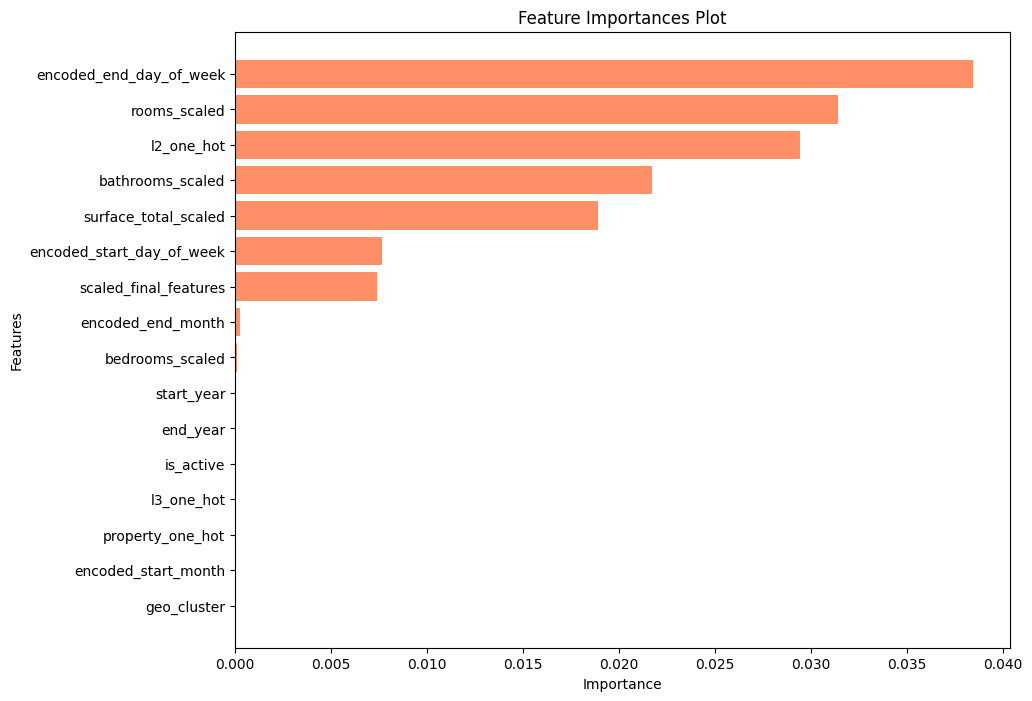

In [80]:
features, importances = zip(*sorted_features)

# Creating the bar plot
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='orangered', alpha = .6)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances Plot')
plt.gca().invert_yaxis()
plt.show()

*Encoded End Day of Week (Importance: 0.0385)* - This feature, which represents the day of the week when an event ends, encoded numerically, emerges as the most influential in the model. Its relatively higher importance suggests that the timing of an event’s conclusion may significantly affect the price categorization.  
*Rooms Scaled (Importance: 0.0314)* - The scaling of room counts appears to be the second most significant predictor. This indicates that the number of rooms, adjusted for scale, is a crucial factor in determining price segments.  
*L2 One Hot (Importance: 0.0294)* - This one-hot encoded feature, likely representing a categorical geographical or administrative level (such as state or province), plays a notable role in the model, pointing to the importance of location in pricing.  
*Bathrooms Scaled (Importance: 0.0217)* and *Surface Total Scaled (Importance: 0.0189)* - These features reflect physical attributes of properties (number of bathrooms and total surface area, respectively), both adjusted for scale, highlighting that larger and better-equipped properties tend to fall into specific price categories.  
*Encoded Start Day of Week (Importance: 0.0077)* and *Scaled Final Features (Importance: 0.0074)* - These features show moderate importance, indicating that the start day of the week and other combined scaled metrics also influence price classification to a lesser extent.  
Minimal Importance Features - Several features such as Encoded End Month, Bedrooms Scaled, Start Year, End Year, IsActive, L3 One Hot, Property One Hot, Encoded Start Month, and Geo Cluster have negligible or zero importances. This minimal impact suggests that these aspects, including time-specific (year, month) and certain categorical or encoded variables, do not significantly affect the price bucket determination in the current model configuration.

### Decision Trees Classifier

In [82]:
# Select relevant features
selected_features=['encoded_end_day_of_week', 'rooms_scaled', 'l2_one_hot','bathrooms_scaled','surface_total_scaled', 'encoded_start_day_of_week','scaled_final_features',
 'encoded_end_month',
'bedrooms_scaled']

# Target variable
target_variable = 'price_bucket'

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
data = assembler.transform(sale_df)

# Split the data into training and testing sets
(trainingData, testData) = data.randomSplit([0.7, 0.3], 33)

# Train a DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol=target_variable, featuresCol="features")

# Train the model
dc_model = dt.fit(trainingData)

# Predictions
predictions_dc_all = dc_model.transform(testData)

# Evaluator
evaluator_dc_all = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="accuracy"
)

# accuracy
accuracy = evaluator_dc_all.evaluate(predictions_dc_all)
print("Test accuracy = %g" % accuracy)

Test accuracy = 0.498638


=> It correctly predicts the correct class for about half of the test data.

In [83]:
# Convert DataFrame predictions to RDD
predictionAndLabels = predictions_dc_all.select("prediction", target_variable).rdd.map(lambda row: (float(row["prediction"]), float(row[target_variable])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix)

for label in sorted(set(predictionAndLabels.map(lambda x: x[1]).collect())):
    print(f"Class {label} precision: {metrics.precision(label)}")
    print(f"Class {label} recall: {metrics.recall(label)}")
    print(f"Class {label} F1 Score: {metrics.fMeasure(label)}")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[9186. 1904.  948.  320.  135.]
 [3383. 4976. 2376. 1287.  188.]
 [2033. 2993. 3020. 3006.  669.]
 [1394. 1135. 1999. 4149. 2636.]
 [1772.  348.  855. 2086. 9965.]]
Class 0.0 precision: 0.5169968482665466
Class 0.0 recall: 0.735291763387497
Class 0.0 F1 Score: 0.6071180727669278
Class 1.0 precision: 0.4381824586121874
Class 1.0 recall: 0.40753480753480753
Class 1.0 F1 Score: 0.4223033183399813
Class 2.0 precision: 0.3283322461404653
Class 2.0 recall: 0.25765719648494156
Class 2.0 F1 Score: 0.2887327310100865
Class 3.0 precision: 0.382466814159292
Class 3.0 recall: 0.36674622116149563
Class 3.0 F1 Score: 0.3744415865710031
Class 4.0 precision: 0.7330979180460531
Class 4.0 recall: 0.66318381472115
Class 4.0 F1 Score: 0.696390509801181


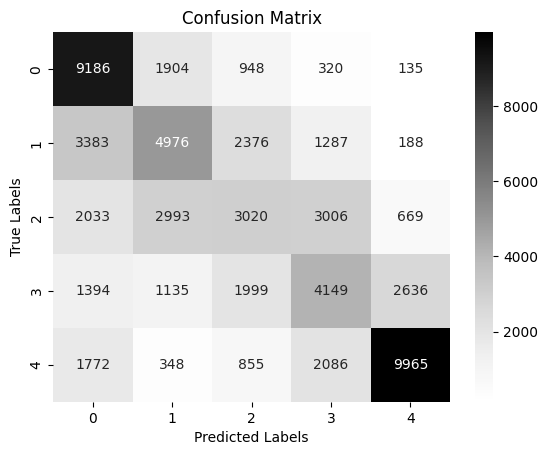

In [84]:
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Greys')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The model performs best in identifying class 0 and class 4, with higher F1 scores suggesting more reliable performance in these categories.
Classes 1, 2, and 3 show considerable room for improvement, especially in precision, which is critical for reducing false positives.
The confusion matrix visually confirms these findings as the darker squares (indicating higher counts) on the diagonal for classes 0 and 4 show higher correct predictions, while lighter squares for classes 1, 2, and 3 indicate frequent misclassifications.

### Random Forest Classifier

In [85]:
# Train a RandomForestClassifier
rf_classifier = RandomForestClassifier(
    labelCol=target_variable,
    featuresCol="features",
    numTrees=20,  # Number of trees in the forest
    maxDepth=5    # Maximum depth of each tree
)

# Train the model
model_rf_all = rf_classifier.fit(trainingData)

# Make predictions
predictions_rf_all = model_rf_all.transform(testData)

evaluator_rf_all = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="accuracy"
)

# Accuracy
accuracy = evaluator_rf_all.evaluate(predictions_rf_all)
print("Test Accuracy = %g" % accuracy)

Test Accuracy = 0.438905


=> It correctly predicts the outcome less than half of the time.

In [86]:
# Convert DataFrame predictions to RDD
predictionAndLabels = predictions_rf_all.select("prediction", target_variable).rdd.map(lambda row: (float(row["prediction"]), float(row[target_variable])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix)

for label in sorted(set(predictionAndLabels.map(lambda x: x[1]).collect())):
    print(f"Class {label} precision: {metrics.precision(label)}")
    print(f"Class {label} recall: {metrics.recall(label)}")
    print(f"Class {label} F1 Score: {metrics.fMeasure(label)}")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[9.693e+03 1.247e+03 1.870e+02 0.000e+00 1.366e+03]
 [4.010e+03 3.927e+03 7.580e+02 5.000e+00 3.510e+03]
 [2.457e+03 2.333e+03 1.371e+03 1.500e+01 5.545e+03]
 [1.651e+03 7.040e+02 7.140e+02 9.600e+01 8.148e+03]
 [2.390e+03 1.110e+02 6.100e+01 4.000e+00 1.246e+04]]
Class 0.0 precision: 0.47982773130043066
Class 0.0 recall: 0.77587448971424
Class 0.0 F1 Score: 0.592952835382639
Class 1.0 precision: 0.4718817591925018
Class 1.0 recall: 0.3216216216216216
Class 1.0 F1 Score: 0.38252483927527764
Class 2.0 precision: 0.443545778065351
Class 2.0 recall: 0.1169695418479652
Class 2.0 F1 Score: 0.18512017283283824
Class 3.0 precision: 0.8
Class 3.0 recall: 0.008485812781755503
Class 3.0 F1 Score: 0.01679349252164786
Class 4.0 precision: 0.4015598311257211
Class 4.0 recall: 0.8292293358179156
Class 4.0 F1 Score: 0.5410921724025622


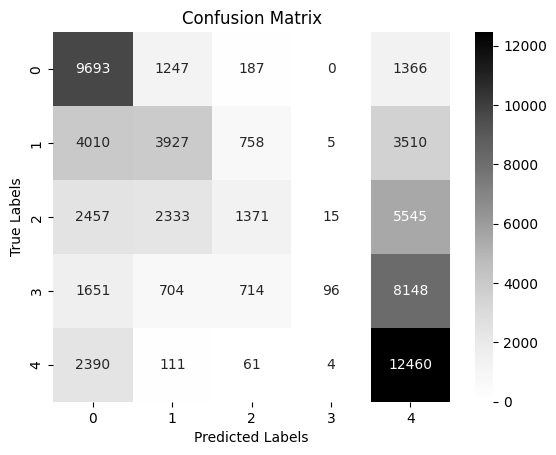

In [87]:
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Greys')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

*Imbalance in Precision and Recall:* The model shows a clear imbalance between precision and recall in multiple classes. High recall and low precision in several classes suggest the classifier is biased toward predicting these classes more frequently, possibly at the expense of other classes.  
*Varying F1 Scores:* The F1 scores vary significantly across classes, indicating uneven performance. Classes with higher F1 scores (like class 0 and class 4) are handled relatively better by the model compared to others.  
*Problematic Areas:* Class 2 and Class 3, in particular, show poor performance metrics, suggesting that the model struggles to learn patterns specific to these classes or that there may be insufficient examples or distinguishing features.

### Linear SVC

In [88]:
# Train a LinearSVC classifier (base classifier for OneVsRest)
base_classifier = LinearSVC(maxIter=10, regParam=0.1)

# Instantiate the OneVsRest classifier
ovr = OneVsRest(classifier=base_classifier, labelCol=target_variable)

# Train the model
model_svm_all = ovr.fit(trainingData)

# Predictions
predictions_svm_all = model_svm_all.transform(testData)

evaluator_svm_all = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="accuracy"
)

# Accuracy
accuracy = evaluator_svm_all.evaluate(predictions_svm_all)
print("Test accuracy = %g" % accuracy)

Test accuracy = 0.691777


=> It correctly predicts the correct class in about 69% of cases

In [89]:
# Convert DataFrame predictions to RDD
predictionAndLabels = predictions_svm_all.select("prediction", target_variable).rdd.map(lambda row: (float(row["prediction"]), float(row[target_variable])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix)

for label in sorted(set(predictionAndLabels.map(lambda x: x[1]).collect())):
    print(f"Class {label} precision: {metrics.precision(label)}")
    print(f"Class {label} recall: {metrics.recall(label)}")
    print(f"Class {label} F1 Score: {metrics.fMeasure(label)}")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[10412.  1366.   267.   122.   326.]
 [ 2194.  7941.  1122.   476.   477.]
 [ 1221.  1848.  5968.  1452.  1232.]
 [  674.   647.  1047.  5728.  3217.]
 [  564.   159.   216.   718. 13369.]]
Class 0.0 precision: 0.6911384002655161
Class 0.0 recall: 0.8334267189626191
Class 0.0 F1 Score: 0.7556426446041077
Class 1.0 precision: 0.6639077000250815
Class 1.0 recall: 0.6503685503685503
Class 1.0 F1 Score: 0.6570683877373712
Class 2.0 precision: 0.6923433874709977
Class 2.0 recall: 0.5091715723914342
Class 2.0 F1 Score: 0.5867951428150042
Class 3.0 precision: 0.6741996233521658
Class 3.0 recall: 0.506320162644745
Class 3.0 F1 Score: 0.578322984501994
Class 4.0 precision: 0.7179528489339992
Class 4.0 recall: 0.8897244775722082
Class 4.0 F1 Score: 0.7946622284304693


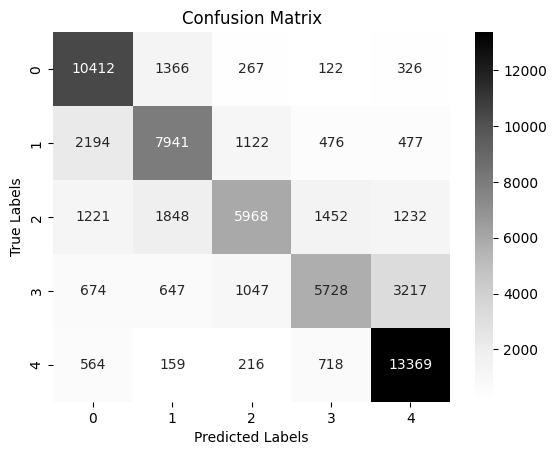

In [90]:
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Greys')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

*Strengths:* The model performs best in predicting class 4, showing both high precision and recall. Class 0 also shows strong recall, although its precision could be improved.  
*Weaknesses:* Classes 2 and 3 have lower recall rates, indicating potential difficulties in identifying these classes correctly. These classes could benefit from targeted improvements in feature selection, model training, or class-specific tuning.

## <u>**With all the features**</u>

#### Decision Trees

In [91]:
features=['scaled_final_features','start_year', 'end_year', 'is_active',
         'l3_one_hot', 'l2_one_hot', 'property_one_hot', 'encoded_start_month',
         'encoded_end_month', 'encoded_start_day_of_week', 'encoded_end_day_of_week',
         'geo_cluster', 'rooms_scaled', 'bedrooms_scaled', 'bathrooms_scaled',
         'surface_total_scaled']

# Target variable
target_variable = 'price_bucket'

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(sale_df)

# Train a DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol=target_variable, featuresCol="features")

# Train the model
dc_model = dt.fit(trainingData)

# Make predictions
predictions_dc_all = dc_model.transform(testData)

evaluator_dc_all = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="accuracy"
)

# Accuracy
accuracy = evaluator_dc_all.evaluate(predictions_dc_all)
print("Test accuracy = %g" % accuracy)

Test accuracy = 0.498638


=> Approximately 49.9%, indicates that the decision model correctly predicts the outcome nearly half of the time.

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[9186. 1904.  948.  320.  135.]
 [3383. 4976. 2376. 1287.  188.]
 [2033. 2993. 3020. 3006.  669.]
 [1394. 1135. 1999. 4149. 2636.]
 [1772.  348.  855. 2086. 9965.]]
Class 0.0 precision: 0.5169968482665466
Class 0.0 recall: 0.735291763387497
Class 0.0 F1 Score: 0.6071180727669278
Class 1.0 precision: 0.4381824586121874
Class 1.0 recall: 0.40753480753480753
Class 1.0 F1 Score: 0.4223033183399813
Class 2.0 precision: 0.3283322461404653
Class 2.0 recall: 0.25765719648494156
Class 2.0 F1 Score: 0.2887327310100865
Class 3.0 precision: 0.382466814159292
Class 3.0 recall: 0.36674622116149563
Class 3.0 F1 Score: 0.3744415865710031
Class 4.0 precision: 0.7330979180460531
Class 4.0 recall: 0.66318381472115
Class 4.0 F1 Score: 0.696390509801181


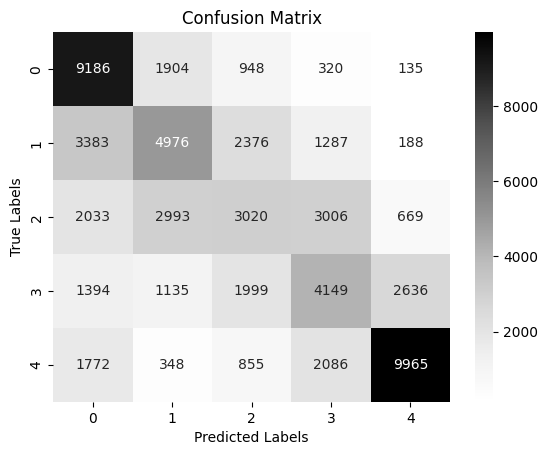

In [92]:
predictionAndLabels = predictions_dc_all.select("prediction", target_variable).rdd.map(lambda row: (float(row["prediction"]), float(row[target_variable])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix)

for label in sorted(set(predictionAndLabels.map(lambda x: x[1]).collect())):
    print(f"Class {label} precision: {metrics.precision(label)}")
    print(f"Class {label} recall: {metrics.recall(label)}")
    print(f"Class {label} F1 Score: {metrics.fMeasure(label)}")

sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Greys')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<u>Class 0:</u>  
Precision: 51.70%  
Recall: 73.53%  
F1 Score: 60.71%  
Observations: High recall but moderate precision suggests the model identifies most actual Class 0 instances but also incorrectly labels many other instances as Class 0.   

<u>Class 1:</u>  
Precision: 43.82%  
Recall: 40.75%  
F1 Score: 42.23%  
Observations: Both precision and recall are moderate to low, indicating struggles in correctly identifying and distinguishing Class 1 instances.  

<u>Class 2:</u>  
Precision: 32.83%  
Recall: 25.77%  
F1 Score: 28.87%  
Observations: Both metrics are low, especially recall, suggesting significant challenges in detecting Class 2 instances.  

<u>Class 3:</u>  
Precision: 38.25%  
Recall: 36.67%  
F1 Score: 37.44%  
Observations: Similar to Class 2, both precision and recall are low, which indicates poor model performance on Class 3.  

<u>Class 4:</u>  
Precision: 73.31%  
Recall: 66.32%  
F1 Score: 69.64%  
Observations: The strongest performance among the classes with the highest precision and recall, suggesting that features relevant to Class 4 are well represented and utilized by the model.

#### Random Forest

In [93]:
# Train a RandomForestClassifier
rf_classifier = RandomForestClassifier(
    labelCol=target_variable,
    featuresCol="features",
    numTrees=20,  # Number of trees in the forest
    maxDepth=5    # Maximum depth of each tree
)

# Train the model
model_rf_all = rf_classifier.fit(trainingData)

# Make predictions
predictions_rf_all = model_rf_all.transform(testData)

evaluator_rf_all = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="accuracy"
)

# Accuracy
accuracy = evaluator_rf_all.evaluate(predictions_rf_all)
print("Test Accuracy = %g" % accuracy)

Test Accuracy = 0.438905


=> It correctly predicts the correct class in about 44% of cases

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[9.693e+03 1.247e+03 1.870e+02 0.000e+00 1.366e+03]
 [4.010e+03 3.927e+03 7.580e+02 5.000e+00 3.510e+03]
 [2.457e+03 2.333e+03 1.371e+03 1.500e+01 5.545e+03]
 [1.651e+03 7.040e+02 7.140e+02 9.600e+01 8.148e+03]
 [2.390e+03 1.110e+02 6.100e+01 4.000e+00 1.246e+04]]
Class 0.0 precision: 0.47982773130043066
Class 0.0 recall: 0.77587448971424
Class 0.0 F1 Score: 0.592952835382639
Class 1.0 precision: 0.4718817591925018
Class 1.0 recall: 0.3216216216216216
Class 1.0 F1 Score: 0.38252483927527764
Class 2.0 precision: 0.443545778065351
Class 2.0 recall: 0.1169695418479652
Class 2.0 F1 Score: 0.18512017283283824
Class 3.0 precision: 0.8
Class 3.0 recall: 0.008485812781755503
Class 3.0 F1 Score: 0.01679349252164786
Class 4.0 precision: 0.4015598311257211
Class 4.0 recall: 0.8292293358179156
Class 4.0 F1 Score: 0.5410921724025622


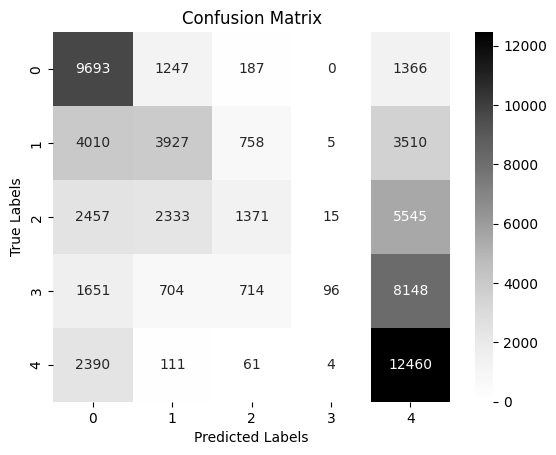

In [94]:
predictionAndLabels = predictions_rf_all.select("prediction", target_variable).rdd.map(lambda row: (float(row["prediction"]), float(row[target_variable])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix)

for label in sorted(set(predictionAndLabels.map(lambda x: x[1]).collect())):
    print(f"Class {label} precision: {metrics.precision(label)}")
    print(f"Class {label} recall: {metrics.recall(label)}")
    print(f"Class {label} F1 Score: {metrics.fMeasure(label)}")

sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Greys')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<u>Class 0:</u>  
Precision: 47.98% - Slightly under half of the predictions made for class 0 are accurate.  
Recall: 77.59% - A high percentage of actual class 0 instances are correctly identified, although at the cost of precision.  
F1 Score: 59.30% - Indicates a decent balance between precision and recall, albeit more skewed towards recall.  
<u>Class 1:</u>  
Precision: 47.19% - Similar to class 0, under half of the predictions for class 1 are correct.  
Recall: 32.16% - This class has a significantly lower recall compared to class 0, indicating many actual class 1 instances go undetected.  
F1 Score: 38.25% - Reflects the need for improvement in both precision and recall.  
<u>Class 2:</u>  
Precision: 44.35% - The precision remains low, similar to classes 0 and 1.  
Recall: 11.70% - Significantly low, suggesting the model struggles substantially in identifying class 2 instances.  
F1 Score: 18.51% - Very low, highlighting this class as a major area of weakness for the model.  
<u>Class 3:</u>  
Precision: 80.00% - Notably high, indicating when class 3 is predicted, it is very likely to be correct.  
Recall: 0.85% - Extremely low, almost all actual class 3 instances are missed.  
F1 Score: 1.68% - Reflects an extremely poor balance due to the low recall rate.  
<u>Class 4:</u>  
Precision: 40.16% - The lowest precision among all classes.  
Recall: 82.93% - High, suggesting that while the model frequently predicts class 4, many are false positives.  
F1 Score: 54.11% - Relatively higher, but still indicative of the need to balance recall with precision.

#### Linear SVC ❤

In [95]:
# Train a LinearSVC classifier (base classifier for OneVsRest)
base_classifier = LinearSVC(maxIter=10, regParam=0.1)

# Instantiate the OneVsRest classifier
ovr = OneVsRest(classifier=base_classifier, labelCol=target_variable)

# Train the model
model_svm_all = ovr.fit(trainingData)

# Make predictions
predictions_svm_all = model_svm_all.transform(testData)

evaluator_svm_all = MulticlassClassificationEvaluator(
    labelCol=target_variable,
    predictionCol="prediction",
    metricName="accuracy"
)

# Compute the accuracy
accuracy = evaluator_svm_all.evaluate(predictions_svm_all)
print("Test accuracy = %g" % accuracy)

Test accuracy = 0.691777


=> It correctly predicts the correct class in about 69% of cases

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[10412.  1366.   267.   122.   326.]
 [ 2194.  7941.  1122.   476.   477.]
 [ 1221.  1848.  5968.  1452.  1232.]
 [  674.   647.  1047.  5728.  3217.]
 [  564.   159.   216.   718. 13369.]]
Class 0.0 precision: 0.6911384002655161
Class 0.0 recall: 0.8334267189626191
Class 0.0 F1 Score: 0.7556426446041077
Class 1.0 precision: 0.6639077000250815
Class 1.0 recall: 0.6503685503685503
Class 1.0 F1 Score: 0.6570683877373712
Class 2.0 precision: 0.6923433874709977
Class 2.0 recall: 0.5091715723914342
Class 2.0 F1 Score: 0.5867951428150042
Class 3.0 precision: 0.6741996233521658
Class 3.0 recall: 0.506320162644745
Class 3.0 F1 Score: 0.578322984501994
Class 4.0 precision: 0.7179528489339992
Class 4.0 recall: 0.8897244775722082
Class 4.0 F1 Score: 0.7946622284304693


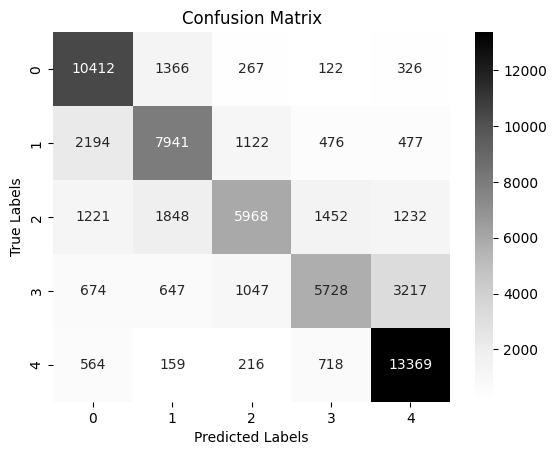

In [96]:
predictionAndLabels = predictions_svm_all.select("prediction", target_variable).rdd.map(lambda row: (float(row["prediction"]), float(row[target_variable])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix)

for label in sorted(set(predictionAndLabels.map(lambda x: x[1]).collect())):
    print(f"Class {label} precision: {metrics.precision(label)}")
    print(f"Class {label} recall: {metrics.recall(label)}")
    print(f"Class {label} F1 Score: {metrics.fMeasure(label)}")

sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Greys')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Class 0:**  
Precision: 69.11%  
Recall: 83.34%  
F1 Score: 75.56%  
Observations: Strong recall indicates effective identification of Class 0 instances, with decent precision suggesting a moderate rate of false positives.  
**Class 1:**  
Precision: 66.39%  
Recall: 65.04%  
F1 Score: 65.71%  
Observations: Balanced precision and recall, indicating reasonable performance but room for improvement to reduce misclassifications.  
**Class 2:**  
Precision: 69.23%  
Recall: 50.92%  
F1 Score: 58.68%  
Observations: While precision is on par with the other classes, the lower recall highlights challenges in consistently identifying Class 2 instances.  
**Class 3:**  
Precision: 67.42%  
Recall: 50.63%  
F1 Score: 57.83%  
Observations: Similar issues as Class 2 with low recall, indicating potential difficulty in detecting true Class 3 instances.  
**Class 4:**  
Precision: 71.80%  
Recall: 88.97%  
F1 Score: 79.47%  
Observations: The best performing class, with high precision and recall, indicating effective identification and low false positive rates.

=> The model demonstrates strong precision, recall, and F1 scores for classes 0.0 and 4.0, indicating its ability to effectively classify instances belonging to these classes. However, for classes 2.0 and 3.0, the model's performance is comparatively weaker, with lower recall and F1 scores. This suggests that the model struggles to correctly identify instances of these classes, potentially leading to misclassifications or false negatives.

#### <u>**Hyperparameter Tunning with 'optuna'**</u> 🧿

In [97]:
! pip install optuna

In [98]:
import optuna

def objective(trial):
    # Values for the hyperparameters
    max_iter = trial.suggest_int('maxIter', 10, 100)
    reg_param = trial.suggest_loguniform('regParam', 1e-4, 1.0)

    # Classifier
    base_classifier = LinearSVC(maxIter=max_iter, regParam=reg_param)
    ovr = OneVsRest(classifier=base_classifier, labelCol=target_variable)

    # Fitting
    model = ovr.fit(trainingData)

    # Predictions
    predictions = model.transform(testData)

    # Evaluation
    evaluator = MulticlassClassificationEvaluator(
        labelCol=target_variable,
        predictionCol="prediction",
        metricName="accuracy"
    )
    accuracy = evaluator.evaluate(predictions)

    return accuracy

# Study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f" Accuracy: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-05-09 19:06:57,314] A new study created in memory with name: no-name-a54c2981-54d9-49b1-b7a8-aaba4cb00a09
<ipython-input-98-fa65d639f15b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg_param = trial.suggest_loguniform('regParam', 1e-4, 1.0)
[I 2024-05-09 19:16:09,651] Trial 0 finished with value: 0.7324857001736692 and parameters: {'maxIter': 40, 'regParam': 0.051703910947791386}. Best is trial 0 with value: 0.7324857001736692.
[I 2024-05-09 19:28:08,554] Trial 1 finished with value: 0.729155712760703 and parameters: {'maxIter': 91, 'regParam': 0.13465404439197734}. Best is trial 0 with value: 0.7324857001736692.
[I 2024-05-09 19:38:36,869] Trial 2 finished with value: 0.738747351146376 and parameters: {'maxIter': 64, 'regParam': 0.01622154226727319}. Best is trial 2 with value: 0.738747351146376.
[I 2024-05-09 19

Best trial:
 Accuracy: 0.7423163328712776
 Params: 
    maxIter: 89
    regParam: 0.00040848369791241586


<span style="color:red"><u>After ALL THESE technical difficulties we encountered, here are the final results!</u></span>


The hyperparameter optimization process conducted on the sale dataset aimed to refine the model's performance by systematically exploring various combinations of hyperparameters. Over 10 trials, different values for hyperparameters such as maxIter and regParam were tested to identify the configuration that maximized accuracy.

Among the trials, a notable improvement in accuracy was observed, with the best-performing trial achieving an accuracy of 74.2%. This trial utilized maxIter set to 89 and regParam set to 0.00041.